<a href="https://colab.research.google.com/github/ramansandhu17/A-B-Testing/blob/main/casual_inference_impact_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import files
upload=files.upload()

Saving ab_data.csv to ab_data.csv
Saving countries.csv to countries.csv


In [5]:
df=pd.read_csv('ab_data.csv')

#df.head()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294480 entries, 0 to 294479
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294480 non-null  int64 
 1   timestamp     294480 non-null  object
 2   group         294480 non-null  object
 3   landing_page  294480 non-null  object
 4   converted     294480 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [10]:
#Get the unique values per column

for col in df.columns:
  print(f'{col}:{df[col].unique()}')

print(df['group'].value_counts())
print(df['landing_page'].value_counts())
print(df['converted'].value_counts())




group
treatment    147278
control      147202
Name: count, dtype: int64
landing_page
new_page    147241
old_page    147239
Name: count, dtype: int64
converted
0    259243
1     35237
Name: count, dtype: int64


In [11]:
#COUNT OF CONVERSION RATE
conversion_rate=df['converted'].mean()
print(f'Overall conversion rate: {conversion_rate:.2f}')

Overall conversion rate: 0.12


In [15]:
#Grouped conversion
grouped = df.groupby('group')['converted'].agg(['count', 'mean']).reset_index()
grouped.columns = ['Group', 'User Count', 'Conversion Rate']
print(grouped)

       Group  User Count  Conversion Rate
0    control      147202         0.120399
1  treatment      147278         0.118918


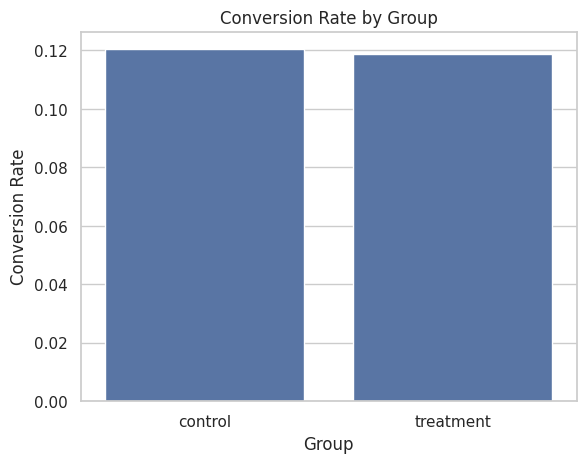

In [21]:
#Plot visually

sns.barplot(data=grouped,x='Group',y='Conversion Rate')
#making it a bit more fancy

sns.set(style="whitegrid")

plt.title('Conversion Rate by Group')
plt.xlabel('Group')
plt.ylabel('Conversion Rate')
plt.show()

In [22]:
#Estimate the Average treatment effect = Conversion rate of treatment - conversion rate of control group

treatment_rate=grouped.loc[grouped['Group']=='treatment','Conversion Rate'].item()
control_rate=grouped.loc[grouped['Group']=='control','Conversion Rate'].item()

ate=treatment_rate-control_rate
print(f'Estimated Average Treatment Effect: {ate:.2f}')


Estimated Average Treatment Effect: -0.00


The treatment group had basically the same or slightly worse conversion rate compared to the control group. Since the difference is so mall, it is likely not meaningful.
We have to perform hypothesis test using a z-test for proportions in A/B test to find out if the small difference is just random noise or statistically significant

In [25]:
pip install statsmodels

In [27]:

from statsmodels.stats.proportion import proportions_ztest

converted_counts = df.groupby('group')['converted'].sum()
sample_sizes = df.groupby('group')['converted'].count()

# Checking the order
successes = [converted_counts['treatment'], converted_counts['control']]
nobs = [sample_sizes['treatment'], sample_sizes['control']]

# Run z-test
z_stat, p_value = proportions_ztest(count=successes, nobs=nobs, alternative='two-sided')

print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")

Z-statistic: -1.2383
P-value: 0.2156


Even though your ATE was around -0.00, this confirms that the new checkout page likely had no real impact on conversions — and any tiny difference is probably just random chance.

In [ ]:
#digging deaeper into Propensity Score Matching

In [28]:
# Keep only valid rows where group and page match
df_clean = df[((df['group'] == 'treatment') & (df['landing_page'] == 'new_page')) |
              ((df['group'] == 'control') & (df['landing_page'] == 'old_page'))].copy()

df_clean['treatment'] = (df_clean['group'] == 'treatment').astype(int)

df_clean[['user_id', 'group', 'landing_page', 'converted', 'treatment']].head()


,user_id,group,landing_page,converted,treatment
0,851104,control,old_page,0,0
1,804228,control,old_page,0,0
2,661590,treatment,new_page,0,1
3,853541,treatment,new_page,0,1
4,864975,control,old_page,1,0


In [31]:
countries=pd.read_csv('countries.csv')
countries.head()

#Merge with clean df
df_merged=df_clean.merge(countries,on='user_id')

df_merged[['user_id','treatment','country','converted']].head()

,user_id,treatment,country,converted
0,851104,0,US,0
1,804228,0,US,0
2,661590,1,US,0
3,853541,1,US,0
4,864975,0,US,1


In [34]:
#One Hot encoding country

df_encoded=pd.get_dummies(df_merged,columns=['country'])

#define features and target
X=df_encoded[['country_UK','country_US']]
Y=df_encoded['treatment']

In [35]:
#fit logistic regression

from sklearn.linear_model import LogisticRegression

logreg=LogisticRegression()
logreg.fit(X,Y)

df_encoded['propensity_score']=logreg.predict_proba(X)[:,1]

df_encoded[['user_id', 'treatment', 'propensity_score']].head()

,user_id,treatment,propensity_score
0,851104,0,0.500566
1,804228,0,0.500566
2,661590,1,0.500566
3,853541,1,0.500566
4,864975,0,0.500566


In [36]:
from sklearn.neighbors import NearestNeighbors

# Split treatment and control groups
treated = df_encoded[df_encoded['treatment'] == 1]
control = df_encoded[df_encoded['treatment'] == 0]

# Fit NearestNeighbors on control group scores
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])

# Find closest control user for each treated user
distances, indices = nn.kneighbors(treated[['propensity_score']])

# Get matched control users
matched_control = control.iloc[indices.flatten()].copy()
matched_treated = treated.reset_index(drop=True).copy()

# Combine into matched set
matched_df = pd.concat([matched_treated, matched_control], ignore_index=True)

# Preview
matched_df[['user_id', 'treatment', 'converted', 'propensity_score']].head()


,user_id,treatment,converted,propensity_score
0,661590,1,0,0.500566
1,853541,1,0,0.500566
2,679687,1,1,0.499939
3,817355,1,1,0.498395
4,839785,1,1,0.499939


In [37]:
# Recalculate ATE: difference in mean conversion between groups
treated_conversion = matched_df[matched_df['treatment'] == 1]['converted'].mean()
control_conversion = matched_df[matched_df['treatment'] == 0]['converted'].mean()
matched_ate = treated_conversion - control_conversion

print(f"Treated group conversion rate: {treated_conversion:.4f}")
print(f"Control group conversion rate: {control_conversion:.4f}")
print(f"ATE after matching: {matched_ate:.4f}")


Treated group conversion rate: 0.1188
Control group conversion rate: 0.2485
ATE after matching: -0.1297


Once we controlled for country differences, we discovered the new checkout page probably made things worse — it led to fewer purchases. So if the company rolls this out to everyone, it could actually hurt sales.